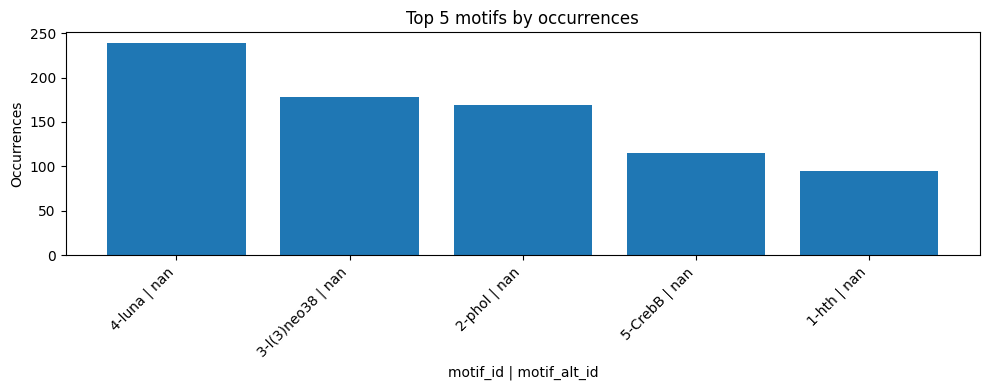

In [26]:
# Jupyter cell: Collapsible "dropdown" analysis for FIMO results (motif counts first)
import pandas as pd
import io
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt

# ---- Settings you can edit ----
TOP_N = 20  # change this number to show more/less motifs in the chart/table

# ---- Load FIMO results ----
fimo_path = "../fimo_files/fimo.tsv"

with open(fimo_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

data_str = "".join([ln for ln in lines if not ln.lstrip().startswith("#")])
df = pd.read_csv(io.StringIO(data_str), sep="\t")

# Helper to pick motif label columns
def get_motif_label_columns(columns):
    has_id = "motif_id" in columns
    has_alt = "motif_alt_id" in columns
    if has_id and has_alt:
        return ["motif_id", "motif_alt_id"]
    if has_alt:
        return ["motif_alt_id"]
    if has_id:
        return ["motif_id"]
    for candidate in ["motif", "Motif", "MOTIF"]:
        if candidate in columns:
            return [candidate]
    return []

motif_label_cols = get_motif_label_columns(df.columns)
if not motif_label_cols:
    raise ValueError("Could not find a motif ID column (e.g., 'motif_id' or 'motif_alt_id') in the TSV.")

# Build a display label
if len(motif_label_cols) == 2:
    label_series = df[motif_label_cols[0]].astype(str) + " | " + df[motif_label_cols[1]].astype(str)
    label_name = f"{motif_label_cols[0]} | {motif_label_cols[1]}"
else:
    label_series = df[motif_label_cols[0]].astype(str)
    label_name = motif_label_cols[0]

counts = label_series.value_counts().rename_axis(label_name).reset_index(name="occurrences")


# Summary
total_hits = len(df)
n_motifs = counts.shape[0]


# Plot bar chart for top N (one figure, no custom colors/styles)
topn = counts.head(TOP_N)
plt.figure(figsize=(10, 4 + max(0, len(topn) - 10) * 0.15))
plt.bar(topn.iloc[:, 0], topn["occurrences"])
plt.xticks(rotation=45, ha="right")
plt.xlabel(counts.columns[0])
plt.ylabel("Occurrences")
plt.title(f"Top {len(topn)} motifs by occurrences")
plt.tight_layout()
plt.show()



## 1. Sum of match scores per motif

,motif_label,score
3,luna,1838.816170
2,l(3)neo38,1518.175370
1,hth,905.572340
0,CrebB,729.293600
4,phol,341.846721


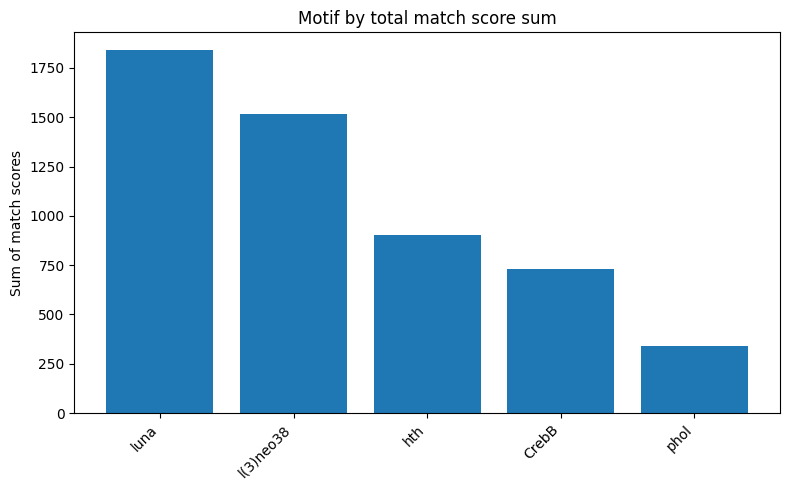

## 2. Number of unique genes with ≥1 hit per motif

,motif_label,gene
3,luna,45
4,phol,43
2,l(3)neo38,39
1,hth,36
0,CrebB,31


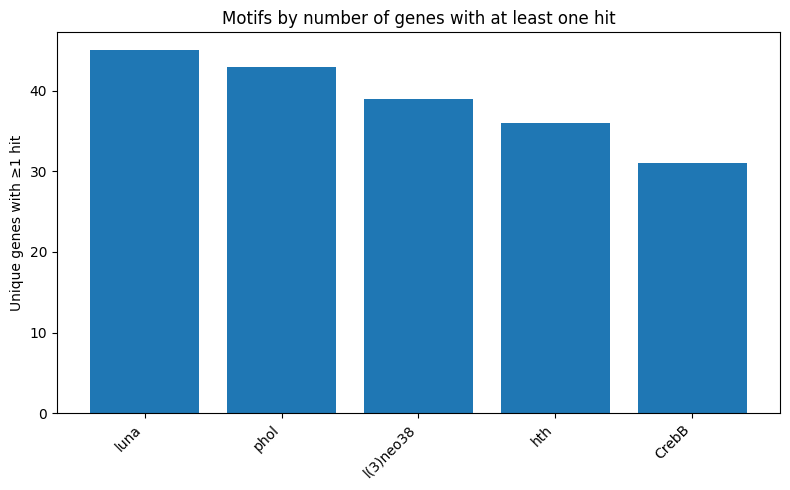

## 3. Best-hit-per-gene: sum of best scores per motif

,motif_label,score
3,luna,436.673320
1,hth,365.786430
2,l(3)neo38,343.278670
4,phol,239.265145
0,CrebB,218.100910


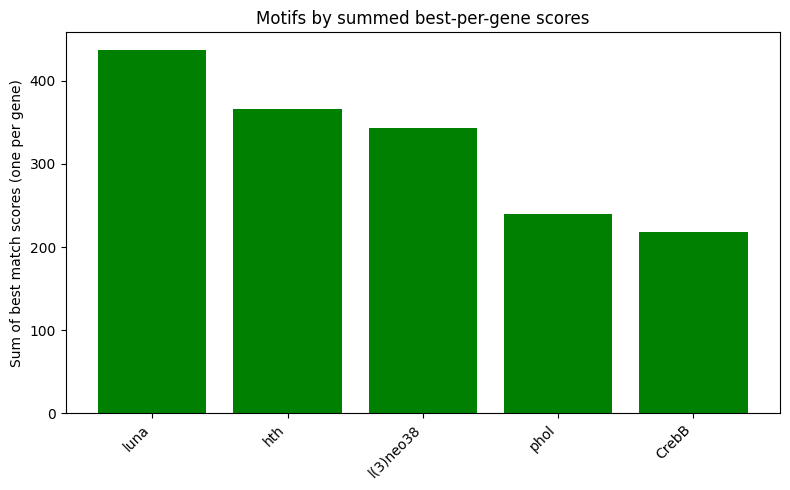

In [27]:
with open(fimo_path, "r", encoding="utf-8") as f:
    lines = f.readlines()
data_str = "".join([ln for ln in lines if not ln.lstrip().startswith("#")])
df = pd.read_csv(io.StringIO(data_str), sep="\t")

# Detect motif label
def get_motif_label_columns(columns):
    has_id = "motif_id" in columns
    has_alt = "motif_alt_id" in columns
    if has_id:
        return ["motif_id"]
    for candidate in ["motif", "Motif", "MOTIF"]:
        if candidate in columns:
            return [candidate]
    return []

motif_label_cols = get_motif_label_columns(df.columns)
if len(motif_label_cols) == 1:
    df["motif_label"] = df[motif_label_cols[0]].astype(str).str.split("-").str[1]
else:
    raise ValueError("No motif label column found.")

# Extract gene name from sequence_name (before underscore)
if "sequence_name" not in df.columns:
    raise ValueError("Expected 'sequence_name' column not found in FIMO output.")
df["gene"] = df["sequence_name"].astype(str).str.split("_").str[0]

TOP_N = 20  # for plotting

# --- 1. Sum of match scores per motif ---
if "score" not in df.columns:
    raise ValueError("Expected 'score' column not found in FIMO output.")
motif_score_sums = df.groupby("motif_label")["score"].sum().reset_index().sort_values("score", ascending=False)

# --- 2. Unique genes with ≥1 hit per motif ---
motif_gene_counts = df.groupby("motif_label")["gene"].nunique().reset_index().sort_values("gene", ascending=False)

# --- 3. Best hit per gene per motif ---
best_hits = df.sort_values("score", ascending=False).groupby(["motif_label", "gene"], as_index=False).first()
best_score_sums = best_hits.groupby("motif_label")["score"].sum().reset_index().sort_values("score", ascending=False)

# ---- Display results ----
display(Markdown("## 1. Sum of match scores per motif"))
display(motif_score_sums.head(TOP_N))

plt.figure(figsize=(8, 5))
plt.bar(motif_score_sums["motif_label"], motif_score_sums["score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Sum of match scores")
plt.title(f"Motif by total match score sum")
plt.tight_layout()
plt.show()

display(Markdown("## 2. Number of unique genes with ≥1 hit per motif"))
display(motif_gene_counts.head(TOP_N))

plt.figure(figsize=(8, 5))
plt.bar(motif_gene_counts["motif_label"], motif_gene_counts["gene"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Unique genes with ≥1 hit")
plt.title(f"Motifs by number of genes with at least one hit")
plt.tight_layout()
plt.show()

display(Markdown("## 3. Best-hit-per-gene: sum of best scores per motif"))
display(best_score_sums.head(TOP_N))

plt.figure(figsize=(8, 5))
plt.bar(best_score_sums["motif_label"], best_score_sums["score"], color="green")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Sum of best match scores (one per gene)")
plt.title(f"Motifs by summed best-per-gene scores")
plt.tight_layout()
plt.show()

# Save outputs to CSV for download


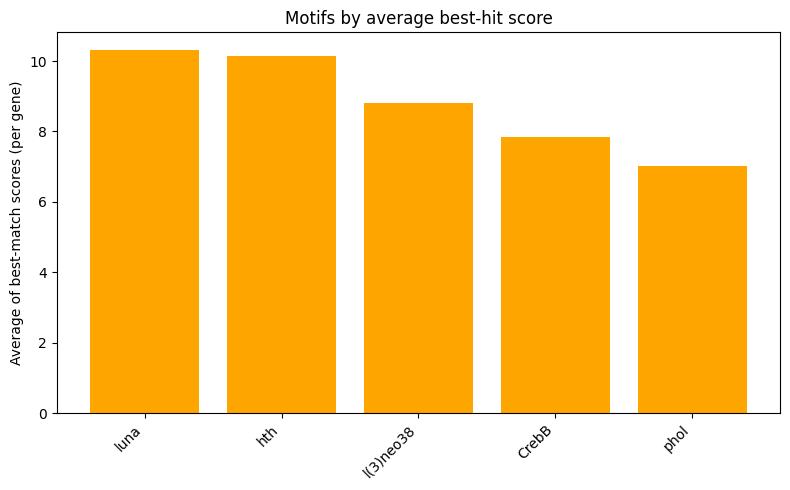

In [24]:
# Average of best-hit scores per motif
avg_best_scores = (best_hits
                   .groupby("motif_label")["score"]
                   .mean()
                   .reset_index()
                   .sort_values("score", ascending=False))
topn_df = avg_best_scores
plt.figure(figsize=(8, 5))
plt.bar(topn_df["motif_label"], topn_df["score"], color="orange")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average of best-match scores (per gene)")
plt.title(f"Motifs by average best-hit score")
plt.tight_layout()
plt.show()

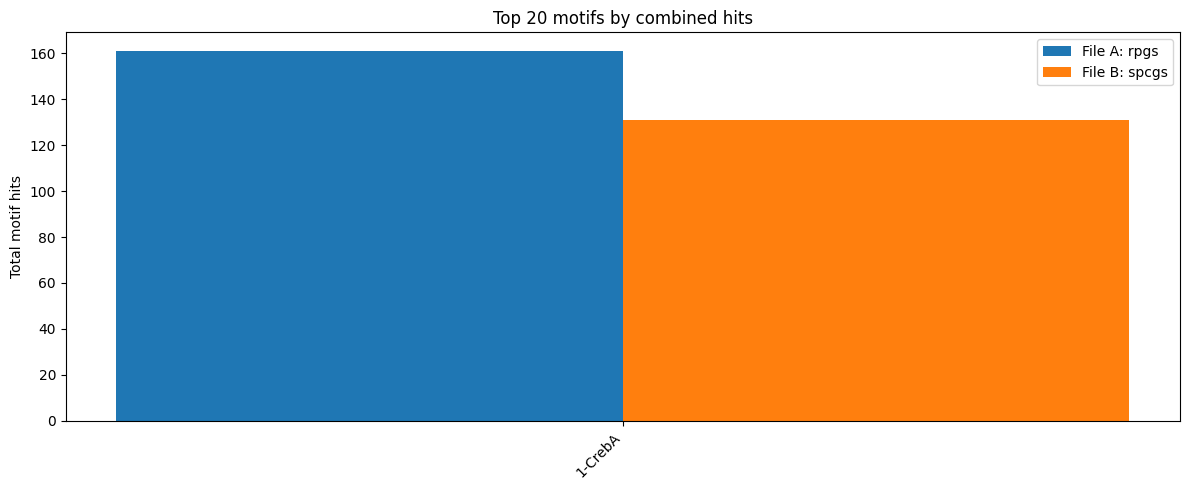

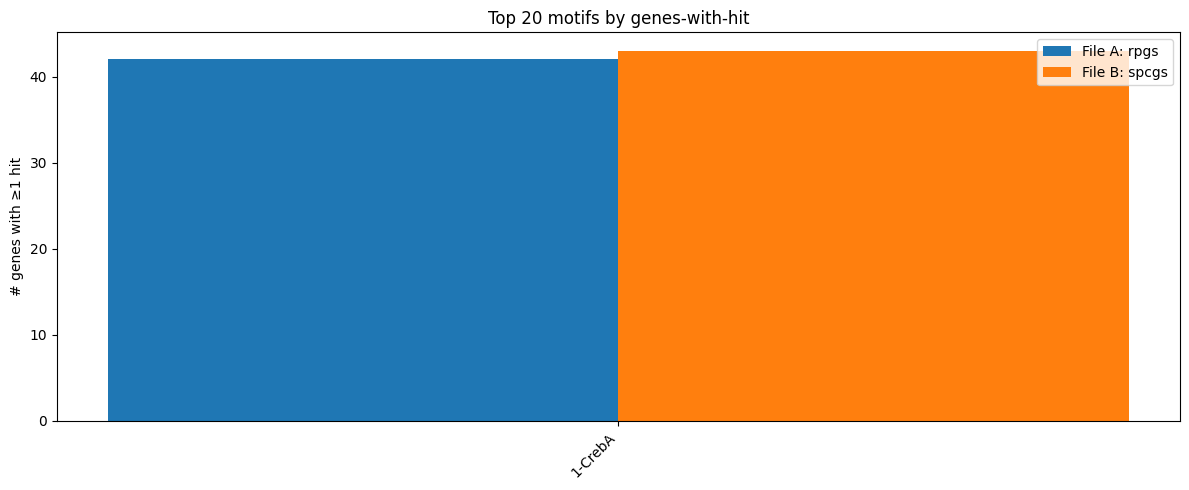

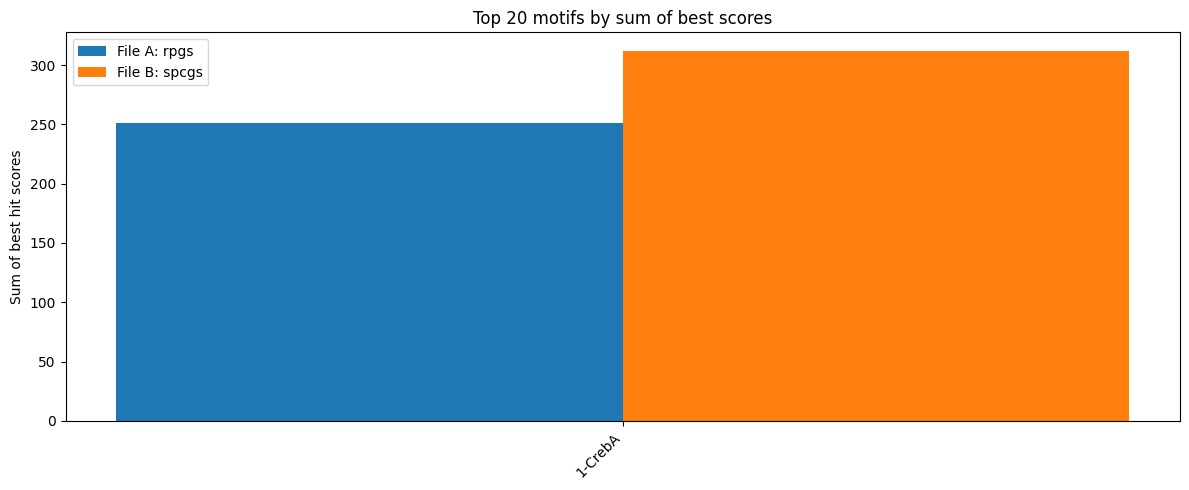

/var/folders/fq/5tx3gdns3wb_2c22jz7wrp4r0000gn/T/ipykernel_58193/101262915.py:171: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([per_gene["total_hits_per_gene_A"], per_gene["total_hits_per_gene_B"]], labels=["A: rpgs", "B: spcgs"], showmeans=True)


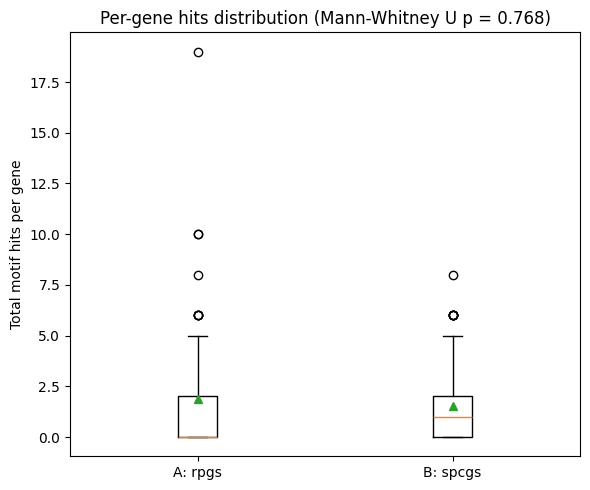

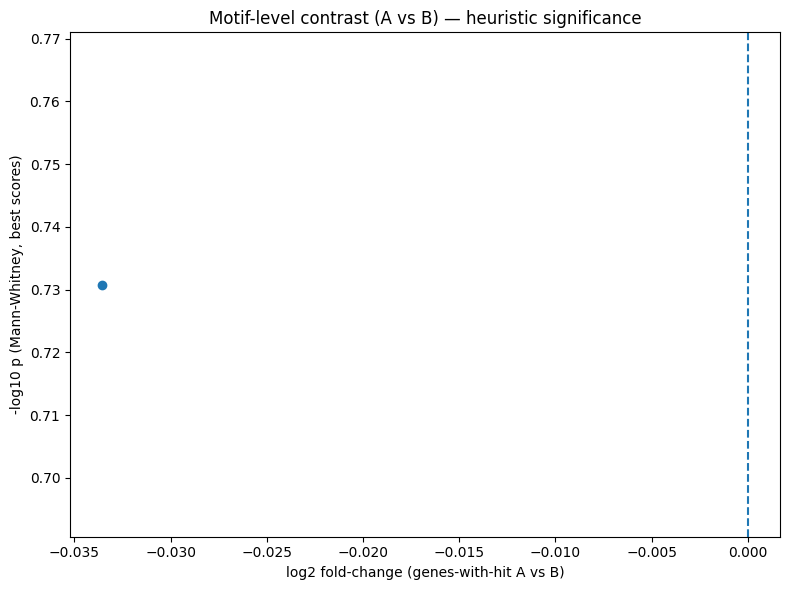

In [2]:
# This script compares motif hits across two FIMO TSV files (each representing a different gene list).
# It computes per-motif summaries, merges them for side-by-side comparison, performs nonparametric tests
# on per-gene hit distributions, and generates a few clear matplotlib charts (no seaborn).

import os
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# ---- File paths (already uploaded) ----
file_a = "/Users/vidyaajay/Desktop/Andrew Lab/VIDEO Analysis/rpgs_fimo_250_0.001.tsv"   # e.g., ribosomal protein genes (user-provided)
file_b = "/Users/vidyaajay/Desktop/Andrew Lab/VIDEO Analysis/spcgs_fimo_250_0.001.tsv"  # e.g., spermatogenesis candidate genes (user-provided)

# ---- Load FIMO outputs ----
def load_fimo(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t", comment="#", low_memory=False)
    # Standard FIMO columns: motif_id, motif_alt_id, sequence_name, start, stop, strand, score, p-value, q-value, matched_sequence
    # Make column names consistent (handle hyphens etc.)
    df.columns = [c.strip().replace(" ", "_").replace("-", "_").lower() for c in df.columns]
    # Ensure required columns exist
    needed = ["motif_id", "sequence_name", "score"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {path}: {missing}. Columns present: {df.columns.tolist()}")
    return df

a = load_fimo(file_a)
b = load_fimo(file_b)

# ---- Extract gene name from sequence_name ----
# Assumes sequence_name looks like 'GENE_transcriptID' or 'GENE|transcript' or 'GENE:transcript'.
# We'll try multiple separators and fallback to the full string.
def extract_gene(name: str) -> str:
    for sep in ["_", "|", ":", ";"]:
        if sep in name:
            return name.split(sep)[0]
    return name

a["gene"] = a["sequence_name"].astype(str).map(extract_gene)
b["gene"] = b["sequence_name"].astype(str).map(extract_gene)

# ---- Per-motif summaries ----
def summarize_per_motif(df: pd.DataFrame, label: str) -> pd.DataFrame:
    # Basic aggregations
    grp = df.groupby("motif_id", as_index=False).agg(
        hits=( "motif_id", "count"),
        sum_score=("score", "sum"),
        genes_with_hit=("gene", "nunique"),
    )
    # Best hit per gene (max score), then aggregate per motif
    best = df.groupby(["motif_id", "gene"], as_index=False)["score"].max()
    best_agg = best.groupby("motif_id", as_index=False).agg(
        sum_best_scores=("score", "sum"),
        mean_best_score=("score", "mean"),
        median_best_score=("score", "median"),
        n_genes_best=("gene", "nunique"),
    )
    out = grp.merge(best_agg, on="motif_id", how="left")
    # Add totals useful for rate calculations
    out["total_unique_genes_in_file"] = df["gene"].nunique()
    # Add label prefix to columns (except motif_id) for later merge clarity
    out = out.rename(columns={c: f"{c}_{label}" for c in out.columns if c != "motif_id"})
    return out

sum_a = summarize_per_motif(a, "A")
sum_b = summarize_per_motif(b, "B")

# ---- Merge A vs B summaries ----
merged = sum_a.merge(sum_b, on="motif_id", how="outer").fillna(0)

# Add log2 fold-changes (with small pseudocounts to avoid div-by-zero)
def log2fc(x, y, pseudocount=0.5):
    return np.log2((x + pseudocount) / (y + pseudocount))

merged["log2fc_hits_A_vs_B"] = log2fc(merged["hits_A"], merged["hits_B"])
merged["log2fc_genes_with_hit_A_vs_B"] = log2fc(merged["genes_with_hit_A"], merged["genes_with_hit_B"])
merged["log2fc_sum_best_scores_A_vs_B"] = log2fc(merged["sum_best_scores_A"], merged["sum_best_scores_B"])

# ---- Per-gene distributions across ALL motifs (global comparison) ----
# Compute per-gene total hits across all motifs within each file, then test difference in distributions.
per_gene_hits_a = a.groupby("gene")["motif_id"].count().rename("total_hits_per_gene_A")
per_gene_hits_b = b.groupby("gene")["motif_id"].count().rename("total_hits_per_gene_B")

# Align into a combined DataFrame (outer join: genes are different sets)
per_gene = pd.concat([per_gene_hits_a, per_gene_hits_b], axis=1).fillna(0)

# Mann-Whitney U test (nonparametric) comparing distributions of total hits per gene
try:
    u_stat, u_p = stats.mannwhitneyu(per_gene["total_hits_per_gene_A"], per_gene["total_hits_per_gene_B"], alternative="two-sided")
except ValueError:
    # If all values are equal or one of the groups is empty
    u_stat, u_p = np.nan, np.nan

# ---- Optional motif-level distribution tests ----
# For each motif, compare the *per-gene best scores* distributions between A & B using Mann-Whitney U.
def motif_level_tests(a_df, b_df):
    res = []
    # Build best per gene per motif tables
    best_a = a_df.groupby(["motif_id", "gene"], as_index=False)["score"].max()
    best_b = b_df.groupby(["motif_id", "gene"], as_index=False)["score"].max()
    motifs = sorted(set(best_a["motif_id"]).union(best_b["motif_id"]))
    for m in motifs:
        x = best_a.loc[best_a["motif_id"] == m, "score"].values
        y = best_b.loc[best_b["motif_id"] == m, "score"].values
        if len(x) >= 1 and len(y) >= 1 and not (np.all(x == x[0]) and np.all(y == y[0]) and x[0] == y[0]):
            try:
                stat, p = stats.mannwhitneyu(x, y, alternative="two-sided")
            except ValueError:
                stat, p = np.nan, np.nan
        else:
            stat, p = np.nan, np.nan
        res.append({"motif_id": m, "mw_stat": stat, "mw_pvalue": p, "n_genes_A": len(x), "n_genes_B": len(y)})
    return pd.DataFrame(res)

motif_tests = motif_level_tests(a, b)

# Merge motif-level tests into the main table
merged = merged.merge(motif_tests, on="motif_id", how="left")

# ---- Save comparison table ----
#out_csv = "/mnt/data/motif_comparison_A_vs_B.csv"
merged_sorted = merged.sort_values(by=["hits_A", "hits_B"], ascending=False)
#merged_sorted.to_csv(out_csv, index=False)

# ---- Plotting (matplotlib only, one chart per figure, no explicit colors) ----

# 1) Top 20 motifs by combined hits (A+B) — side-by-side bars for hits
topN = 20
merged_sorted["combined_hits"] = merged_sorted["hits_A"] + merged_sorted["hits_B"]
top = merged_sorted.sort_values("combined_hits", ascending=False).head(topN)

x = np.arange(len(top))
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, top["hits_A"], width, label="File A: rpgs")
plt.bar(x + width/2, top["hits_B"], width, label="File B: spcgs")
plt.xticks(x, top["motif_id"], rotation=45, ha="right")
plt.ylabel("Total motif hits")
plt.title(f"Top {topN} motifs by combined hits")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Top 20 motifs — genes with at least one hit (side-by-side bars)
plt.figure(figsize=(12, 5))
plt.bar(x - width/2, top["genes_with_hit_A"], width, label="File A: rpgs")
plt.bar(x + width/2, top["genes_with_hit_B"], width, label="File B: spcgs")
plt.xticks(x, top["motif_id"], rotation=45, ha="right")
plt.ylabel("# genes with ≥1 hit")
plt.title(f"Top {topN} motifs by genes-with-hit")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Top 20 motifs — sum of best scores (side-by-side bars)
plt.figure(figsize=(12, 5))
plt.bar(x - width/2, top["sum_best_scores_A"], width, label="File A: rpgs")
plt.bar(x + width/2, top["sum_best_scores_B"], width, label="File B: spcgs")
plt.xticks(x, top["motif_id"], rotation=45, ha="right")
plt.ylabel("Sum of best hit scores")
plt.title(f"Top {topN} motifs by sum of best scores")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Global per-gene total hits distributions — basic boxplots to compare A vs B
plt.figure(figsize=(6, 5))
plt.boxplot([per_gene["total_hits_per_gene_A"], per_gene["total_hits_per_gene_B"]], labels=["A: rpgs", "B: spcgs"], showmeans=True)
plt.ylabel("Total motif hits per gene")
plt.title(f"Per-gene hits distribution (Mann-Whitney U p = {u_p:.3g})")
plt.tight_layout()
plt.show()

# 5) Volcano-like plot: log2FC (genes_with_hit) vs -log10 p (motif-level MW tests)
# Note: p-values come from per-gene best-score distributions and are heuristic; interpret cautiously.
volc = merged_sorted.copy()
volc["neglog10_p"] = -np.log10(volc["mw_pvalue"].replace(0, np.nan))
plt.figure(figsize=(8, 6))
plt.scatter(volc["log2fc_genes_with_hit_A_vs_B"], volc["neglog10_p"])
plt.xlabel("log2 fold-change (genes-with-hit A vs B)")
plt.ylabel("-log10 p (Mann-Whitney, best scores)")
plt.title("Motif-level contrast (A vs B) — heuristic significance")
plt.axvline(0, linestyle="--")
plt.tight_layout()
plt.show()



In [2]:
from pathlib import Path
import pandas as pd
import re

src = Path('/Users/vidyaajay/Desktop/Andrew Lab/hkb_fimo.tsv')

# Load FIMO output (skips comment lines that start with '#')
df = pd.read_csv(src, sep="\t", comment="#")

# Normalize column names (FIMO usually has: motif_id, motif_alt_id, sequence_name, start, stop, strand, score, p-value, q-value, matched_sequence)
df.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in df.columns]

# Parse gene & transcript from sequence_name
# Assumes "GENE_TRANSCRIPTID" (e.g., "dhd_FBtr0331261"); adjusts for '|' too
def parse_gene_tx(name: str):
    m = re.match(r"^(?P<gene>[^_|]+)[_|](?P<transcript>.+)$", str(name))
    if m:
        return pd.Series({"gene": m.group("gene"), "transcript": m.group("transcript")})
    m2 = re.match(r"^(?P<gene>[^|]+)\|(?P<transcript>.+)$", str(name))
    if m2:
        return pd.Series({"gene": m2.group("gene"), "transcript": m2.group("transcript")})
    return pd.Series({"gene": str(name), "transcript": pd.NA})

parsed = df["sequence_name"].apply(parse_gene_tx)
df = pd.concat([df, parsed], axis=1)

# Add position helpers
df["hit_start"]  = df["start"].astype(int)
df["hit_end"]    = df["stop"].astype(int)
df["hit_len"]    = df["hit_end"] - df["hit_start"] + 1
df["hit_center"] = (df["hit_start"] + df["hit_end"]) / 2.0

# Order for readability
cols_order = [
    "gene", "transcript",
    "motif_id", "motif_alt_id",
    "hit_start", "hit_end", "hit_len", "hit_center",
    "strand", "score", "p_value", "q_value", "matched_sequence", "sequence_name"
]
cols_order = [c for c in cols_order if c in df.columns]
tidy = df[cols_order].sort_values(["gene", "transcript", "motif_id", "hit_start", "hit_end"]).reset_index(drop=True)

# Optional compact view: all hits summarized per transcript like "MOTIF: start-end(strand)"
def fmt_hit(row):
    return f"{row['motif_id']}:{row['hit_start']}-{row['hit_end']}({row['strand']})"

compact = (
    tidy.assign(_hit=lambda d: d.apply(fmt_hit, axis=1))
        .groupby(["gene", "transcript"], dropna=False)["_hit"]
        .apply(lambda s: ", ".join(s))
        .reset_index(name="hits_summary")
        .sort_values(["gene", "transcript"])
)

# Save
##tidy.to_csv("/mnt/data/fimo_hits_tidy.csv", index=False)
#compact.to_csv("/mnt/data/fimo_hits_by_transcript_compact.csv", index=False)


In [3]:
compact

,gene,transcript,hits_summary
0,Dr,FBtr0085441,"1-hkb:41-49(-), 1-hkb:456-464(-), 1-hkb:656-66..."
1,hkb,FBtr0078951,"1-hkb:128-136(+), 1-hkb:357-365(-), 1-hkb:402-..."
2,klar,FBtr0072565,"1-hkb:629-637(-), 1-hkb:966-974(-), 1-hkb:1531..."
3,klar,FBtr0112807,"1-hkb:529-537(+), 1-hkb:1800-1808(+)"
4,klar,FBtr0333852,"1-hkb:140-148(+), 1-hkb:522-530(+)"
5,klar,FBtr0343527,"1-hkb:93-101(+), 1-hkb:1073-1081(+), 1-hkb:142..."


In [4]:
tidy

,gene,transcript,motif_id,motif_alt_id,hit_start,hit_end,hit_len,hit_center,strand,score,p_value,q_value,matched_sequence,sequence_name
0,Dr,FBtr0085441,1-hkb,NaN,41,49,9,45.0,-,4.11224,0.000574,0.582,GGAGCGGGA,Dr_FBtr0085441
1,Dr,FBtr0085441,1-hkb,NaN,456,464,9,460.0,-,6.51020,0.000216,0.501,TTGGCGTGA,Dr_FBtr0085441
2,Dr,FBtr0085441,1-hkb,NaN,656,664,9,660.0,+,11.32650,0.000049,0.273,TAGGCGTGC,Dr_FBtr0085441
3,Dr,FBtr0085441,1-hkb,NaN,1744,1752,9,1748.0,-,3.23469,0.000717,0.582,TGGGCGAGG,Dr_FBtr0085441
4,Dr,FBtr0085441,1-hkb,NaN,1768,1776,9,1772.0,-,4.79592,0.000365,0.573,GCGGCGTGC,Dr_FBtr0085441
5,Dr,FBtr0085441,1-hkb,NaN,1808,1816,9,1812.0,-,3.54082,0.000664,0.582,TTGGCGGGA,Dr_FBtr0085441
6,Dr,FBtr0085441,1-hkb,NaN,1826,1834,9,1830.0,-,4.53061,0.000391,0.573,GCGGCGGGA,Dr_FBtr0085441
7,Dr,FBtr0085441,1-hkb,NaN,1844,1852,9,1848.0,-,12.60200,0.000031,0.269,TGGGCGTGG,Dr_FBtr0085441
8,Dr,FBtr0085441,1-hkb,NaN,1886,1894,9,1890.0,-,3.10204,0.000806,0.582,TGGGCATGT,Dr_FBtr0085441
9,Dr,FBtr0085441,1-hkb,NaN,1961,1969,9,1965.0,-,9.06122,0.000097,0.388,GAGGCGGGT,Dr_FBtr0085441


In [9]:
# Update: subset to only klar isoforms and convert positions to be relative to TSS.
# Assumptions:
# - Each sequence is a 1001bp window from TSS-500..TSS+500 (inclusive), with TSS at position 501 (1-based).
# - Relative positions: rel_pos = abs_pos - 501, so TSS is 0, upstream negative, downstream positive.

df = pd.read_csv(src, sep="\t", comment="#")
df.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in df.columns]

def parse_gene_tx(name: str):
    m = re.match(r"^(?P<gene>[^_|]+)[_|](?P<transcript>.+)$", str(name))
    if m:
        return pd.Series({"gene": m.group("gene"), "transcript": m.group("transcript")})
    m2 = re.match(r"^(?P<gene>[^|]+)\|(?P<transcript>.+)$", str(name))
    if m2:
        return pd.Series({"gene": m2.group("gene"), "transcript": m2.group("transcript")})
    return pd.Series({"gene": str(name), "transcript": pd.NA})

parsed = df["sequence_name"].apply(parse_gene_tx)
df = pd.concat([df, parsed], axis=1)

# 1) subset to 'klar' isoforms (case-insensitive, trims whitespace)
df["gene_norm"] = df["gene"].astype(str).str.strip().str.lower()
df_klar = df[df["gene_norm"] == "klar"].copy()

# If no klar rows, still proceed with empty frame to avoid exceptions
if df_klar.empty:
    # Create empty outputs with the expected schema
    tidy_klar = pd.DataFrame(columns=[
        "gene","transcript","motif_id","motif_alt_id","rel_start","rel_end","rel_len",
        "rel_center","strand","score","p_value","q_value","matched_sequence","sequence_name"
    ])
    compact_klar = pd.DataFrame(columns=["gene","transcript","hits_summary"])
else:
    # 2) compute relative positions from TSS (TSS at 501, 1-based coordinates)
    tss_pos = 1001
    df_klar["hit_start"] = df_klar["start"].astype(int)
    df_klar["hit_end"] = df_klar["stop"].astype(int)
    df_klar["rel_start"] = df_klar["hit_start"] - tss_pos
    df_klar["rel_end"] = df_klar["hit_end"] - tss_pos
    df_klar["rel_len"] = df_klar["rel_end"] - df_klar["rel_start"] + 1
    df_klar["rel_center"] = (df_klar["rel_start"] + df_klar["rel_end"]) / 2.0

    cols_order = [
        "gene", "transcript",
        "motif_id", "motif_alt_id",
        "rel_start", "rel_end", "rel_len", "rel_center",
        "strand", "score", "p_value", "q_value", "matched_sequence", "sequence_name"
    ]
    cols_order = [c for c in cols_order if c in df_klar.columns]
    tidy_klar = df_klar[cols_order].sort_values(["gene","transcript","motif_id","rel_start","rel_end"]).reset_index(drop=True)

    # Build compact per-transcript summary using relative coords
    def fmt_hit_rel(row):
        return f"{row['motif_id']}:{row['rel_start']}-{row['rel_end']}({row['strand']})"

    compact_klar = (
        tidy_klar.assign(_hit=lambda d: d.apply(fmt_hit_rel, axis=1))
                 .groupby(["gene","transcript"], dropna=False)["_hit"]
                 .apply(lambda s: ", ".join(s))
                 .reset_index(name="hits_summary")
                 .sort_values(["gene","transcript"])
    )

# Save updated files
#out_dir = Path("/mnt/data")
#csv_tidy_klar = out_dir / "fimo_hits_tidy_klar_relTSS.csv"
#csv_compact_klar = out_dir / "fimo_hits_by_transcript_klar_relTSS.csv"

#tidy_klar.to_csv(csv_tidy_klar, index=False)
#compact_klar.to_csv(csv_compact_klar, index=False)

# Show a preview to the user
#display_dataframe_to_user("Klar-only (relative to TSS) – Tidy", tidy_klar.head(100))
#display_dataframe_to_user("Klar-only (relative to TSS) – Compact", compact_klar.head(100))

#csv_tidy_klar, csv_compact_klar


In [10]:
tidy_klar

,gene,transcript,motif_id,motif_alt_id,rel_start,rel_end,rel_len,rel_center,strand,score,p_value,q_value,matched_sequence,sequence_name
0,klar,FBtr0072565,1-hkb,NaN,-372,-364,9,-368.0,-,3.10204,0.000806,0.582,TGTGCGTGT,klar_FBtr0072565
1,klar,FBtr0072565,1-hkb,NaN,-35,-27,9,-31.0,-,2.52041,0.000913,0.606,GAGGTGTGC,klar_FBtr0072565
2,klar,FBtr0072565,1-hkb,NaN,530,538,9,534.0,-,4.62245,0.000386,0.573,CGGGCGTGG,klar_FBtr0072565
3,klar,FBtr0072565,1-hkb,NaN,534,542,9,538.0,-,9.34694,0.000089,0.388,GAGGCGGGC,klar_FBtr0072565
4,klar,FBtr0072565,1-hkb,NaN,611,619,9,615.0,-,6.13265,0.000233,0.501,TGGGCGTCA,klar_FBtr0072565
5,klar,FBtr0112807,1-hkb,NaN,-472,-464,9,-468.0,+,3.54082,0.000664,0.582,TCGGCGGGA,klar_FBtr0112807
6,klar,FBtr0112807,1-hkb,NaN,799,807,9,803.0,+,7.08163,0.000193,0.501,GGCGCGTGA,klar_FBtr0112807
7,klar,FBtr0333852,1-hkb,NaN,-861,-853,9,-857.0,+,8.00000,0.000130,0.404,TGGGCGTTC,klar_FBtr0333852
8,klar,FBtr0333852,1-hkb,NaN,-479,-471,9,-475.0,+,2.87755,0.000821,0.582,AGGGCGGTT,klar_FBtr0333852
9,klar,FBtr0343527,1-hkb,NaN,-908,-900,9,-904.0,+,12.05100,0.000039,0.269,GAGGCGGGA,klar_FBtr0343527


In [11]:
tidy_klar.to_csv('/Users/vidyaajay/Desktop/Andrew Lab/hkb_motif_hits.csv', index=False)